# Walidacja klasyfikacji zbioru danych allegro-api-transaction.
Julia Kaznowska, Piotr Wilczyński <br>
25/03/2022 <br>
Politechnika Warszawska, Wydział Matematyki i Nauk Informacyjnych, Wstęp do uczenia maszynowego

## Import niezbędnych bibliotek oraz zbioru danych

In [152]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)

# zbior danych
allegro_df = pd.read_csv('.\\allegro-api-transactions.csv')

## Podział na dane do budowy i walidacji

Do analizy dostaliśmy następujący podział danych:

In [153]:
allegro_df_build = allegro_df.sample(frac=0.7, random_state=500)
allegro_df_test = allegro_df.drop(allegro_df_build.index)

W naszej opinii lepszy byłby podział warstwowy po zmiennej celu, aczkolwiek aktualnie nie jesteśmy w stanie tego zmienić.

In [154]:
allegro_df_test.reset_index(drop = True, inplace = True)

## Przegląd ramki danych

Zobaczmy kolumny zbioru i jakiego są typu:

In [155]:
allegro_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126006 entries, 0 to 126005
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      126006 non-null  int64  
 1   date                    126006 non-null  object 
 2   item_id                 126006 non-null  int64  
 3   categories              126006 non-null  object 
 4   pay_option_on_delivery  126006 non-null  int64  
 5   pay_option_transfer     126006 non-null  int64  
 6   seller                  126006 non-null  object 
 7   price                   126006 non-null  float64
 8   it_is_allegro_standard  126006 non-null  int64  
 9   it_quantity             126006 non-null  int64  
 10  it_is_brand_zone        126006 non-null  int64  
 11  it_seller_rating        126006 non-null  int64  
 12  it_location             126006 non-null  object 
 13  main_category           126006 non-null  object 
dtypes: float64(1), int64

Ramka składa się z 14 kolumn i 126006 rekordów. Zobaczmy jej pierwsze rekordy.

In [156]:
allegro_df_test.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
1,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
2,5,2016-04-03 16:31:01,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki"
3,6,2016-04-03 17:56:11,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki"
4,7,2016-04-03 11:58:55,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,0,4287,Legionowo,Biżuteria i Zegarki


### Wstępne braki danych

In [157]:
allegro_df_test.isnull().sum()

lp                        0
date                      0
item_id                   0
categories                0
pay_option_on_delivery    0
pay_option_transfer       0
seller                    0
price                     0
it_is_allegro_standard    0
it_quantity               0
it_is_brand_zone          0
it_seller_rating          0
it_location               0
main_category             0
dtype: int64

In [158]:
np.where(allegro_df_test.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

Wstępny przegląd zbioru wykazał, że w ramce nie ma oczywistych braków danych (w postaci null bądź pustych pól).

## Analiza jednowymiarowa

### lp

In [159]:
allegro_df_test['lp'].unique().__len__()

126006

Zmienna unikalna dla każdego rekordu, nie będziemy jej brać pod uwagę przy konstrukcji modelu.

### date

In [160]:
allegro_df_test["date"].value_counts()

2016-04-03 22:32:33    64
2016-04-03 22:32:46    48
2016-04-03 10:55:30    44
2016-04-03 20:16:30    40
2016-04-03 16:44:50    40
                       ..
2016-04-03 16:08:45     1
2016-04-03 21:42:21     1
2016-04-03 22:57:35     1
2016-04-03 16:22:56     1
2016-04-03 23:22:53     1
Name: date, Length: 30839, dtype: int64

W tym miejscu (w przeciwieństwie do budowniczych) uznaliśmy, że usuwanie tej kolumny może nie być dobrym posunięciem. Ceny mogą kształtować się inaczej ze względu na rok, na skutek chociażby inflacji. Najpierw sprawdzimy zatem, czy wszystkie rekordy pochodzą z tego samego roku.

In [161]:
pd.DatetimeIndex(allegro_df_test['date']).year.value_counts()

2016    126006
Name: date, dtype: int64

In [162]:
pd.DatetimeIndex(allegro_df_test['date']).month.value_counts()

4    126006
Name: date, dtype: int64

In [163]:
pd.DatetimeIndex(allegro_df_test['date']).day.value_counts()

3    126006
Name: date, dtype: int64

Dzięki temu wiemy, że wszystkie rekordy pochodzą z tego samego dnia - zmienna ta zatem nie powinna mieć większego wpływu na model.

### item_id

In [164]:
allegro_df_test["item_id"].value_counts()

6095133176    35
6061413744    30
6073551689    26
6076113230    23
6091540894    23
              ..
5589631668     1
5556605622     1
6083795647     1
6045870785     1
5524168708     1
Name: item_id, Length: 112748, dtype: int64

Występują powtarzające się przedmioty. 

In [165]:
allegro_df_test.loc[allegro_df_test['item_id']==6095133176].head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
7247,24025,2016-04-03 18:52:46,6095133176,"['Gry', 'Gry online (MMO)', 'Pozostałe']",0,1,Pixelobsessions,3.45,0,10366,0,1298,Lewes,Gry
7248,24028,2016-04-03 11:59:11,6095133176,"['Gry', 'Gry online (MMO)', 'Pozostałe']",0,1,Pixelobsessions,3.45,0,10366,0,1298,Lewes,Gry
7249,24032,2016-04-03 00:39:40,6095133176,"['Gry', 'Gry online (MMO)', 'Pozostałe']",0,1,Pixelobsessions,3.45,0,10366,0,1298,Lewes,Gry
7250,24033,2016-04-03 16:39:44,6095133176,"['Gry', 'Gry online (MMO)', 'Pozostałe']",0,1,Pixelobsessions,3.45,0,10366,0,1298,Lewes,Gry
7251,24036,2016-04-03 20:19:14,6095133176,"['Gry', 'Gry online (MMO)', 'Pozostałe']",0,1,Pixelobsessions,3.45,0,10366,0,1298,Lewes,Gry


Tak jak u budowniczych, występują duplikaty różniące się jedynie <i>lp</i> i <i>date</i>. Warto byłoby je usunąć. Miejsce usunięcia tych duplikatów (w trakcie analizy danych) nie wydaje się być najlepsze, jednak na szczęście z poprzednich kolumn nie będziemy korzystać. 

In [166]:
allegro_df_test.loc[:, ~allegro_df_test.columns.isin(['date','lp'])].drop_duplicates().__len__()

112748

In [167]:
allegro_df_test = allegro_df_test.loc[:, ~allegro_df_test.columns.isin(['date','lp'])].drop_duplicates()

Ramka pomniejszyła się o ponad 10 tysięcy rekordów.

## categories

In [168]:
allegro_df_test["categories"].value_counts()

['Dom i Ogród', 'Ogród', 'Rośliny', 'Rośliny owocowe']                                                  823
['Dom i Ogród', 'Ogród', 'Rośliny', 'Bulwy, cebulki, kłącza']                                           702
['Odzież, Obuwie, Dodatki', 'Odzież damska', 'Sukienki']                                                647
['Dom i Ogród', 'Ogród', 'Rośliny', 'Drzewa i krzewy liściaste']                                        640
['Telefony i Akcesoria', 'Akcesoria GSM', 'Folie ochronne na LCD']                                      616
                                                                                                       ... 
['RTV i AGD', 'Sprzęt audio dla domu', 'Odtwarzacze CD i MD', 'Jednopłytowe', 'Sony']                     1
['RTV i AGD', 'Elektronika', 'Elektronika', 'Chemia dla elektroniki', 'Izolacja', 'Zalewy, lakiery']      1
['Biuro i Reklama', 'Akcesoria biurowe', 'Pieczątki i akcesoria', 'Gumki do pieczątek']                   1
['Dla Dzieci', 'Odzież', 'Sw

Analogicznie do budowniczych, rozbiciem kategorii zajmiemy się później.

### pay_option_on_delivery

In [169]:
allegro_df_test["pay_option_on_delivery"].value_counts()

1    99283
0    13465
Name: pay_option_on_delivery, dtype: int64

<AxesSubplot:>

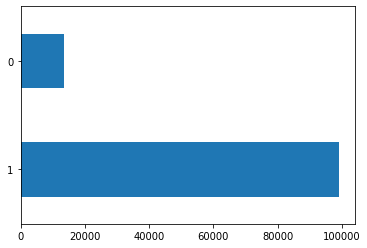

In [170]:
allegro_df_test["pay_option_on_delivery"].value_counts().plot(kind = "barh")

Widzimy, że zdecydowana większość ofert posiada opcję zapłaty przy dostawie.

### pay_option_transfer

In [171]:
allegro_df_test["pay_option_transfer"].value_counts()

1    91719
0    21029
Name: pay_option_transfer, dtype: int64

<AxesSubplot:>

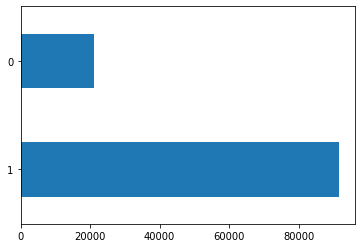

In [172]:
allegro_df_test["pay_option_transfer"].value_counts().plot(kind = "barh")

Widzimy, że zdecydowana większość ofert posiada opcję zapłaty przelewem.

### seller

In [173]:
allegro_df_test["seller"].value_counts()

Allegro          331
darmarsklep      262
Aros_pl          249
sklepogrodnik    246
ezebra_pl        240
                ... 
piter8883          1
micdab30           1
NW34BN             1
Capri10            1
eviva666           1
Name: seller, Length: 29685, dtype: int64

<AxesSubplot:xlabel='counts', ylabel='Count'>

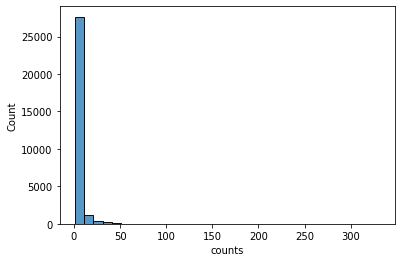

In [174]:
sns.histplot(data=allegro_df_test.groupby(["seller"]).size().reset_index(name="counts"),x="counts", binwidth=10)

In [175]:
df2 = allegro_df_test.groupby(["seller"]).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
df2.loc[df2['counts']<15].__len__()/43862

0.6462769595549679

W przeciwieństwie do budowniczych, na zbiorze walidacyjnym około 64% sprzedających ma poniżej 15 ofert. Opisywanie rozkładu tej zmiennej jako samo sprawdzanie liczby ofert raczej nie ma większego sensu po uprzednim usunięciu ofert z duplikowanymi przedmiotami. Należało by zwrócić uwagę, że jest to rozkład unikalnych ofert.

Dobrym pomysłem wydaje się również dodanie boxplota, który może dać dodatkowy wgląd w rozkład danych.

In [176]:
df3 = allegro_df_test.groupby(["seller"]).size().reset_index(name="counts")

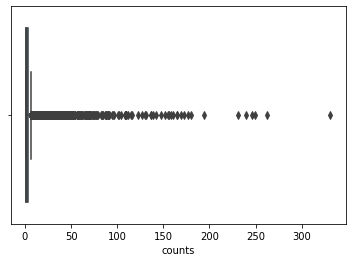

In [177]:
sns.boxplot(x = df3["counts"])
plt.show()

Jak widzimy, występuje tutaj bardzo dużo outlierów, przez które również boxplot staje się niezbyt czytelny. Dobrym wyjściem byłoby zatem dodanie również podstawowych informacji o rozkładzie zmiennych.

In [178]:
df3["counts"].describe()

count    29685.000000
mean         3.798147
std          8.733593
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        331.000000
Name: counts, dtype: float64

### price

<AxesSubplot:>

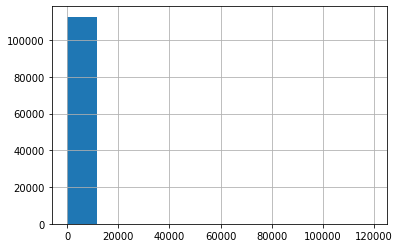

In [179]:
allegro_df_test["price"].hist()

In [180]:
allegro_df_test["price"].sort_values().value_counts()

1.00       2010
9.99       1239
19.99      1122
99.00       928
15.00       866
           ... 
22.25         1
259.30        1
312.42        1
1119.00       1
1259.90       1
Name: price, Length: 6184, dtype: int64

Najczęściej występujące ceny są takie same jak u budowniczych.

Następnie sprawdzamy częstość występowania ceny 0.

In [181]:
allegro_df_test["price"].eq(0).sum()

10

Do analizy tego wyniku budowniczowie wracają w późniejszej części raportu, zatem zrobimy to samo.

In [182]:
allegro_df_test["price"].describe()

count    112748.000000
mean         80.058988
std         556.099404
min           0.000000
25%           9.000000
50%          25.000000
75%          69.000000
max      119000.000000
Name: price, dtype: float64

Rozkład ceny w zbiorze walidacyjnym wydaje się być podobnym do próbki do budowania.

Dodatkowym atutem byłoby również dodanie boxplota dla tej zmiennej.

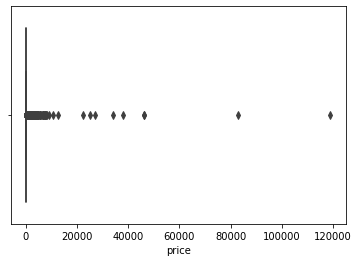

In [183]:
sns.boxplot(x = allegro_df_test["price"])
plt.show()

Tutaj również, podobnie jak przy liczbie przedmiotów sprzedawanych przez sprzedawcę, istnieje wiele outlierów. Dla większych wartości są one jednak mniej skupione.

### it_is_allegro_standard

In [184]:
allegro_df_test["it_is_allegro_standard"].value_counts()

1    66351
0    46397
Name: it_is_allegro_standard, dtype: int64

<AxesSubplot:>

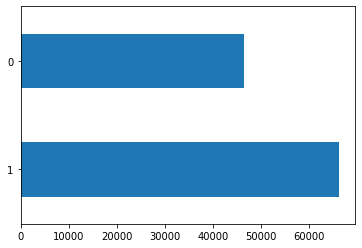

In [185]:
allegro_df_test["it_is_allegro_standard"].value_counts().plot(kind = "barh")

Tak jak u budowniczych, większość przedmiotów posiada standard allegro.

### it_quantity

In [186]:
allegro_df_test["it_quantity"].value_counts()

0        17926
1         3275
2         2462
3         2166
4         2002
         ...  
4318         1
2269         1
8408         1
1015         1
98856        1
Name: it_quantity, Length: 5425, dtype: int64

In [187]:
allegro_df_test["it_quantity"].describe()

count    112748.000000
mean       5759.046901
std       21746.445552
min           0.000000
25%           5.000000
50%          81.000000
75%         908.000000
max       99999.000000
Name: it_quantity, dtype: float64

Rozkład zmiennej <i>it_quantity</i> trochę różni się od zbioru do budowania. Największą różnicę zauważamy dla średniej. 

In [188]:
allegro_df_test["it_quantity"].eq(0).sum()

17926

In [189]:
allegro_df_test["it_quantity"].eq(99999).sum()

94

Podobnie jak dla zmiennej <i>price</i>, budowniczowie zdecydowali się na analizę tych wartości w dalszej części raportu.

<AxesSubplot:xlabel='it_quantity', ylabel='Count'>

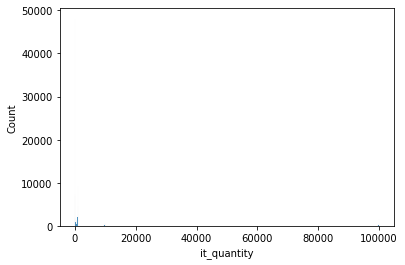

In [190]:
sns.histplot(allegro_df_test,x='it_quantity')

Histogram ten nie daje nam zbyt wielu informacji na temat zmiennej. Argument binwidth nie jest do niej odpowiednio dobrany.

<AxesSubplot:>

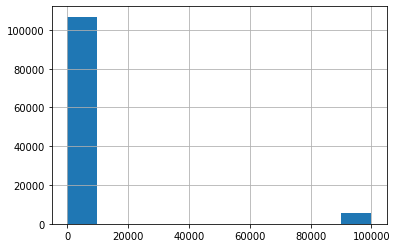

In [191]:
allegro_df_test["it_quantity"].hist()

Na powyższym histogramie widać odrobinę więcej, wiemy jednak, że najpewniej występuje tu sporo outlierów, co warto przedstawić na boxplocie.

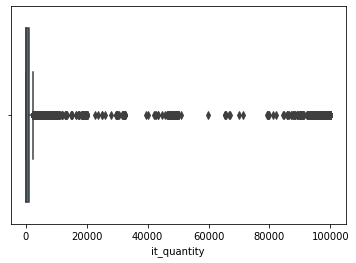

In [192]:
sns.boxplot(x = allegro_df_test["it_quantity"])
plt.show()

### it_is_brand_zone

In [193]:
allegro_df_test["it_is_brand_zone"].value_counts()

0    111075
1      1673
Name: it_is_brand_zone, dtype: int64

<AxesSubplot:>

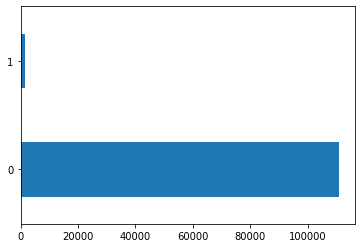

In [194]:
allegro_df_test["it_is_brand_zone"].value_counts().plot(kind = "barh")

Tak jak u budowniczych, przeważająca liczba rekordów posiada flagę 0.

### it_seller_rating

In [195]:
allegro_df_test["it_seller_rating"].value_counts()

0        143
1        107
6         84
4         84
2         83
        ... 
33611      1
90935      1
86044      1
43039      1
13041      1
Name: it_seller_rating, Length: 31283, dtype: int64

In [196]:
allegro_df_test["it_seller_rating"].describe()

count    112748.000000
mean      19378.283845
std       35537.536941
min          -1.000000
25%        1525.000000
50%        6418.000000
75%       20112.000000
max      292074.000000
Name: it_seller_rating, dtype: float64

In [197]:
allegro_df_test["it_seller_rating"].lt(0).sum()

1

O wartości -1 budowniczowie wypowiadają się w dalszej części raportu.

W tym miejscu budowniczowie zdecydowali się z jakiejś przyczyny pokazać histogram dla innej zmiennej niż omawiana (dodatkowo z usuniętymi outlierami).

1


<AxesSubplot:xlabel='it_quantity', ylabel='Count'>

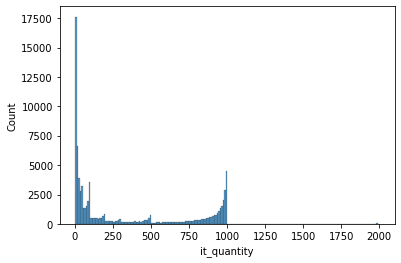

In [198]:
it_quantities = allegro_df_test['it_quantity']

upper_lim =it_quantities.quantile(.90)
lower_lim =it_quantities.quantile(.00)

data_percentile2 =it_quantities[(it_quantities < upper_lim) & (it_quantities > lower_lim)]
print(data_percentile2.min())
sns.histplot(data=data_percentile2,binwidth=10)

Wykres rzeczywiście przedstawia się bardziej czytelnie, jest jednak delikatnie spóźniony.

Histogram dla zmiennej <i>it_seller_rating</i> przedstawia się następująco:

<AxesSubplot:>

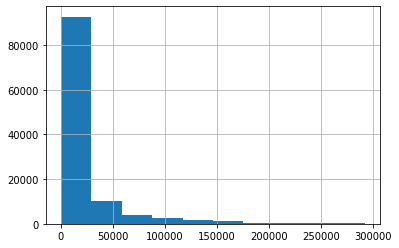

In [199]:
allegro_df_test["it_seller_rating"].hist()

Wykres ten jest mocno skośny w prawo. Zobaczmy rozkład danych na boxplocie.

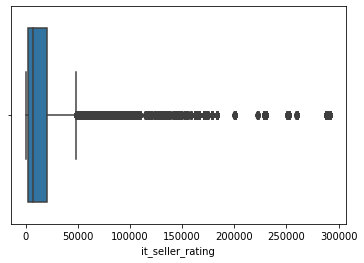

In [200]:
sns.boxplot(x = allegro_df_test["it_seller_rating"])
plt.show()

Boxplot dalej ma wiele outlierów, jest jednak odrobinę czytelniejszy od tych dla poprzednich zmiennych.

### it_location

In [201]:
allegro_df_test["it_location"].value_counts()

Warszawa                         6420
Kraków                           4141
Łódź                             2896
Poznań                           2723
Wrocław                          2392
                                 ... 
Kraków okolice - Jerzmanowice       1
Czeszewo                            1
Czarnowąsy                          1
PODŁĘŻE                             1
Łagów k/ Zgorzelca                  1
Name: it_location, Length: 6692, dtype: int64

Widzimy ponad 6,5 tysiąca różnych lokalizacji. Najprawdopodobniej część z nich będzie można złączyć, ale objaśnianiem tego budowniczowie zajęli się później. 

Z jakiegoś powodu budowniczowie zdecydowali się na wstawienie w tym miejscu następującego fragmentu kodu:

In [202]:
fake_values1 = '!"#$%&\'()*+.:;<=>?@[\\]^_`{|}~@'
fake_values2 = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ 1234567890'
tmp1 = allegro_df_test["it_location"].map((lambda v: any(char in v for char in fake_values1)))

### main_category

In [203]:
allegro_df_test["main_category"].value_counts()

Dom i Ogród                            23724
Odzież, Obuwie, Dodatki                14350
Motoryzacja                            13066
Dla Dzieci                             11454
Sport i Turystyka                       7474
Uroda                                   7245
RTV i AGD                               5547
Telefony i Akcesoria                    5144
Komputery                               3694
Zdrowie                                 3484
Książki i Komiksy                       3328
Delikatesy                              2212
Rękodzieło                              1871
Kolekcje                                1794
Przemysł                                1729
Biżuteria i Zegarki                     1647
Gry                                     1633
Biuro i Reklama                          889
Fotografia                               706
Muzyka                                   573
Antyki i Sztuka                          365
Filmy                                    276
Konsole i 

Cztery najczęstsze kategorie pokrywają się ze zbiorem do budowania. 

## Braki danych

Wnioski (co do braków danych) z analizy jednowymiarowej pokrywają się:
1. Zmienna "price" przyjmuje wartości zerowe.
2. Zmienna "it_quanity" przyjmuje wartości zerowe.
3. Zmienna "it_seller_rating" przyjmuje wartości ujemne.

Podpunkt 4. (Zmienna "it_location" zawiera dużo błędnych danych (prawdopodobnie użytkownik mógł ustawić tę wartość na dowolny ciąg charów ASCII) najprawdopodobniej również jest prawdziwy, aczkolwiek nigdzie wcześniej nie jest przedstawiona żadna błędna wartość.

### price

In [204]:
allegro_df_test["price"].eq(0).sum()

10

Darmowe przedmioty rzeczywiście wydają się być podejrzanymi.

In [205]:
price_zero = allegro_df_test.loc[allegro_df_test["price"] == 0]
price_zero.head()

,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
52921,6087034161,"['Odzież, Obuwie, Dodatki', 'Galanteria i doda...",1,1,alleloombard647,0.0,0,0,0,21,Biała Podlaska,"Odzież, Obuwie, Dodatki"
54886,6090900154,"['Odzież, Obuwie, Dodatki', 'Obuwie', 'Damskie...",0,0,ojanuszczak,0.0,0,0,0,12,Puławy,"Odzież, Obuwie, Dodatki"
54902,6093716954,"['Sport i Turystyka', 'Rowery i akcesoria', 'R...",1,0,Jaareckii,0.0,0,0,0,34,Zielona Góra,Sport i Turystyka
91606,6095509255,"['Komputery', 'Komputery stacjonarne']",1,1,gigusd,0.0,0,0,0,523,Łobez,Komputery
94069,6088787851,"['Telefony i Akcesoria', 'Telefony komórkowe',...",0,0,Madzitka23,0.0,0,0,0,77,Wągrowiec,Telefony i Akcesoria


W tym przypadku rekordy (nie kolumny) najprawdopodobniej można usunąć.

In [206]:
allegro_df_test_fixed = allegro_df_test[allegro_df_test.price != 0]
print(allegro_df_test_fixed.shape)
print(allegro_df_test_fixed.shape)
allegro_df_test_fixed.head()

(112738, 12)
(112738, 12)


,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
1,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
2,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki"
4,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,0,4287,Legionowo,Biżuteria i Zegarki
5,4828603874,"['RTV i AGD', 'Kamery', 'Zasilanie', 'Zasilacze']",1,1,e-trade-com-pl,45.00,1,4,0,15561,Warszawa,RTV i AGD


Uzasadnienie usunięcia danych pokrywa się z wnioskami budowniczych. Tutaj jednak można kłócić się z miejscem usuwania rekordów - a konkretniej przypisywania ich do nowej tabelki, podczas gdy dalsze braki danych wykrywane są na podstawie starej.

### it_quantity

Budowniczowie zdecydowali się na powtórzenie w tym miejscu analizy jednoczynnikowej dla tej zmiennej.

In [207]:
allegro_df_test["it_quantity"].eq(0).sum()

17926

In [208]:
allegro_df_test["it_quantity"].eq(99999).sum()

94

In [209]:
allegro_df_test["it_quantity"].value_counts()

0        17926
1         3275
2         2462
3         2166
4         2002
         ...  
4318         1
2269         1
8408         1
1015         1
98856        1
Name: it_quantity, Length: 5425, dtype: int64

Zgadzamy się jednak z analizą tych danych oraz ścieżką obraną przez budowniczych. 0 może być domyślną watrością a rekordów jest za dużo na ich usunięcie. 

In [210]:
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_quantity"] == 0, "it_quantity"] = 1
allegro_df_test_fixed.head()

,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
1,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
2,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki"
4,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,0,4287,Legionowo,Biżuteria i Zegarki
5,4828603874,"['RTV i AGD', 'Kamery', 'Zasilanie', 'Zasilacze']",1,1,e-trade-com-pl,45.00,1,4,0,15561,Warszawa,RTV i AGD


In [211]:
allegro_df_test_fixed["it_quantity"].value_counts()

1        21191
2         2462
3         2166
4         2002
9         1576
         ...  
98603        1
8479         1
8118         1
2330         1
98352        1
Name: it_quantity, Length: 5424, dtype: int64

### it_seller_rating

In [212]:
allegro_df_test["it_seller_rating"].lt(0).sum()

1

W naszym zbiorze występuje tylko 1 rekord o wartości -1. Jeśli nie jesteśmy w stanie zinterpretować tej wartości, najlepiej będzie ją usunąć.

In [213]:
allegro_df_test_fixed.loc[allegro_df_test_fixed["it_seller_rating"].lt(0), "it_seller_rating"] = 0
allegro_df_test_fixed["it_seller_rating"].describe()

count    112738.000000
mean      19379.993117
std       35538.649554
min           0.000000
25%        1526.000000
50%        6420.000000
75%       20119.000000
max      292074.000000
Name: it_seller_rating, dtype: float64

### it_location

In [214]:
(allegro_df_test_fixed.it_location == "Londyn").sum()

4

Z jakiegoś powodu budowniczowie połączyli wpisywanie dowolnego ciągu znaków z miastem Londyn. 

In [215]:
allegro_df_test_fixed["it_location_raw"] = allegro_df_test_fixed['it_location'].str.replace('[^\w\s]','')
print((allegro_df_test_fixed.it_location_raw == "").sum())
allegro_df_test_fixed.it_location_raw = allegro_df_test_fixed.it_location_raw.str.replace(' ', '')
print((allegro_df_test_fixed.it_location_raw == "").sum())
allegro_df_test_fixed.it_location_raw = allegro_df_test_fixed.it_location_raw.str.replace('\d+', '')
print((allegro_df_test_fixed.it_location_raw == "").sum())

555
555
559


Sam pomysł wypisywania liczby "uszkodzonych" danych jest dobry, wypisywanie jej jednak przy każdym przekształceniu jest trochę mylące. Nie popieramy również usuwania tych rekordów. Lepszym rozwiązaniem byłoby stworzenie nowej wartości typu "brak".

In [216]:
print(allegro_df_test_fixed.shape)
allegro_df_test_fixed = allegro_df_test_fixed[allegro_df_test_fixed.it_location_raw != ""]
print(allegro_df_test_fixed.shape)

(112738, 13)
(112179, 13)


## Przekształcenie zmiennych ciągłych na kategoryczne

### Zakodowanie zmiennej celu

In [217]:
allegro_df_test_fixed['priceEncoded']=pd.qcut(allegro_df_test_fixed['price'], q=3,labels=False)
allegro_df_test_fixed.head()

,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,it_location_raw,priceEncoded
0,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki",Warszawa,0
1,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy,WolaKrzysztoporska,1
2,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki",GĄBIN,0
4,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,0,4287,Legionowo,Biżuteria i Zegarki,Legionowo,1
5,4828603874,"['RTV i AGD', 'Kamery', 'Zasilanie', 'Zasilacze']",1,1,e-trade-com-pl,45.00,1,4,0,15561,Warszawa,RTV i AGD,Warszawa,1


### Zakodowanie it_seller_rating i it_quantity

In [218]:
allegro_df_test_fixed['it_quantityEncoded']=pd.qcut(allegro_df_test_fixed['it_quantity'], q=5,labels=False)
allegro_df_test_fixed['it_seller_ratingEncoded']=pd.qcut(allegro_df_test_fixed['it_seller_rating'], q=5,labels=False)

In [219]:
allegro_df_test_fixed

,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,it_location_raw,priceEncoded,it_quantityEncoded,it_seller_ratingEncoded
0,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki",Warszawa,0,4,3
1,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy,WolaKrzysztoporska,1,4,3
2,4790991674,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,Noemi-bielizna,10.99,1,742,0,39371,GĄBIN,"Odzież, Obuwie, Dodatki",GĄBIN,0,3,4
4,4824025074,"['Biżuteria i Zegarki', 'Zegarki', 'Dziecięce']",1,1,handel_barbo,28.99,1,886,0,4287,Legionowo,Biżuteria i Zegarki,Legionowo,1,3,2
5,4828603874,"['RTV i AGD', 'Kamery', 'Zasilanie', 'Zasilacze']",1,1,e-trade-com-pl,45.00,1,4,0,15561,Warszawa,RTV i AGD,Warszawa,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126001,6098643807,"['Motoryzacja', 'Chemia', 'Oleje silnikowe', '...",1,1,FILTRY_Gdansk,228.99,1,11,0,26880,GDANSK,Motoryzacja,GDANSK,2,1,4
126002,6098828007,"['Dla Dzieci', 'Obuwie', 'Sportowe']",1,1,Sklep_Adrenalina,35.00,0,1,0,4421,Zalesie,Dla Dzieci,Zalesie,1,0,2
126003,6099072807,"['Odzież, Obuwie, Dodatki', 'Galanteria i doda...",0,0,katarzynasz2012,400.00,0,1,0,409,des plaines,"Odzież, Obuwie, Dodatki",desplaines,2,0,0
126004,6099074607,"['Dla Dzieci', 'Zabawki', 'Maskotki', 'Interak...",1,1,arti_barti,200.00,0,1,0,59,Miłkowice,Dla Dzieci,Miłkowice,2,0,0


Kodowanie zmiennych poprzez kwantyle wydaje się być dobrym wyjściem. Jeszcze lepiej byłoby jednak, gdybyśmy pracowali jedynie na potrzebnych nam kolumnach (z jakiegoś powodu zmienna <i>date</i> dostała usunięta, natomiast zmienna <i> id</i> już nie; po zakodowaniu zmiennych nie są potrzebne również ich podstawowe wartości).